In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn import svm
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import precision_score,f1_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
import imblearn
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
#from xgboost import XGBClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [2]:
df=pd.read_csv('C:/Users/dell/Downloads/final_model.csv')

In [3]:
X=df
y=df['class']
del X['class']

In [4]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [5]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_res, y_res = sm.fit_sample(x_train, y_train)

In [6]:
def Classifer(X,y,X2,y2):
    # If we want to change model then edit this chunk
    
    params = { "n_estimators"      : [100,200,500],
               "criterion"         : ["gini", "entropy"],
               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
               "max_depth"         : [3,4,6,10],
               "min_samples_split" : [2, 5, 20,50]}
    param_comb = 5
    clf = RandomForestClassifier()
    skf = StratifiedKFold(n_splits=2, shuffle = True, random_state = 1001)
    random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001)
    #start_time = timer(None) 
    random_search.fit(X,y)
    y_score  = random_search.predict(X2)
    return y_score




In [7]:
 y_score  = Classifer(x_res, y_res, x_test, y_test)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   35.8s remaining:   15.3s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   55.6s finished


In [8]:
def ROC_Values(yTest,yPred):
    y_test = yTest; y_score = yPred
    y_score = label_binarize(y_score, classes=[0, 1, 2, 3])
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3])
    n_classes = y_test.shape[1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr,tpr,roc_auc, n_classes


In [9]:
FPR, TPR, ROC_AUC, NClass= ROC_Values(y_test,y_score)

In [10]:
def ROC_Curve(F,T,RA,NC):
    fpr = F
    tpr = T
    roc_auc = RA; n_classes = NC
    # Plot all ROC curves
    lw = 2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

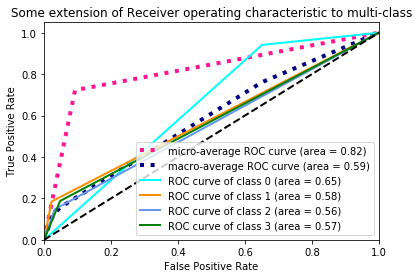

In [11]:
ROC_Curve(FPR, TPR, ROC_AUC,NClass)

In [12]:
def PrecRecall(F,T,RA, Yt,Ys ):    
    fpr = F;tpr = T;roc_auc = RA    
    y_test =Yt; y_score = Ys
    
    y_score = label_binarize(y_score, classes=[0, 1, 2, 3])
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3])
    n_classes = y_test.shape[1]
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.59


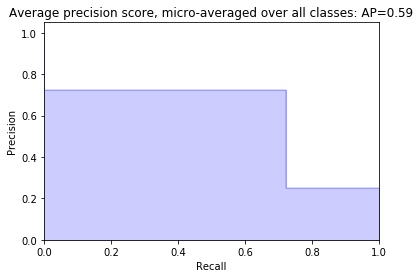

In [13]:
PrecRecall(FPR, TPR, ROC_AUC, y_test, y_score)